## Building and storing the file as pickle file

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

In [2]:
import xgboost
xgboost.__version__

'0.90'

In [3]:
import sklearn
sklearn.__version__

'0.23.2'

## Loading the dataset: Used Car Price Prediction

In [4]:
cars_df = pd.read_csv( "https://drive.google.com/uc?export=download&id=1V_VBbyjGj6vvD0A90S5Lk0DG90djz28B" )

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cars_df = pd.read_csv('/content/drive//MyDrive/Employee_Attrition.csv')

In [62]:
cars_df.head(5)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0


In [48]:
cars_df.Attrition=cars_df.Attrition.map(dict(Yes=1,No=0))

In [63]:
cars_df_dev, cars_df_prod = train_test_split(cars_df,
                                             train_size = 0.8,
                                             random_state = 42)

In [64]:
cars_df_prod = cars_df_prod.reset_index()
cars_df_dev = cars_df_dev.reset_index()

In [65]:
x_columns = ['Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager']
## model of the car is not included in the model

In [66]:
cars_df.shape

(1470, 31)

In [67]:
cars_df = cars_df[x_columns + ['Attrition']].dropna()

In [68]:
cars_df.shape

(1470, 31)

## Identifying numerical and categorical features

In [69]:
cat_features = ['BusinessTravel', 'Department','Education','EnvironmentSatisfaction',
                'EducationField','Gender','JobInvolvement','JobLevel','JobRole','JobSatisfaction',
                'MaritalStatus','PerformanceRating','RelationshipSatisfaction',
                'StockOptionLevel','WorkLifeBalance','OverTime']

In [70]:
num_features = list(set(x_columns) - set(cat_features))

In [71]:
#y=cars_df_dev.Attrition.map(dict(Yes=1,No=0))

## Split the dataset

In [72]:
x_train, x_test, y_train, y_test = train_test_split(cars_df_dev[x_columns],
                                                    cars_df_dev.Attrition,
                                                    train_size = 0.8,
                                                    random_state = 100)

In [73]:
x_train.shape

(940, 30)

## Creating the pipeline for the deployment

In [74]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer, cat_features),
    ])

params = { "n_estimators": 400,
           "max_depth": 4,
           "objective": 'reg:squarederror' }

xgb_regressor = XGBRegressor(**params)

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb_regressor)])           

reg.fit(x_train, 
        y_train)

rmse = np.sqrt(mean_squared_error(y_test, 
                                  reg.predict(x_test)))

In [75]:
print(rmse)

0.33135774189534134


In [76]:
!pip install evidently

## Predicting on Production Set

In [77]:
cars_df_prod['prediction'] = reg.predict(cars_df_prod[x_columns])

### Retriving the dummy variables from the pipeline

In [78]:
new_cat_features = list(reg['preprocessor'].transformers_[1][1].get_feature_names())

In [79]:
new_cat_features

['x0_Non-Travel',
 'x0_Travel_Frequently',
 'x0_Travel_Rarely',
 'x1_Human Resources',
 'x1_Research & Development',
 'x1_Sales',
 'x2_1',
 'x2_2',
 'x2_3',
 'x2_4',
 'x2_5',
 'x3_1',
 'x3_2',
 'x3_3',
 'x3_4',
 'x4_Human Resources',
 'x4_Life Sciences',
 'x4_Marketing',
 'x4_Medical',
 'x4_Other',
 'x4_Technical Degree',
 'x5_Female',
 'x5_Male',
 'x6_1',
 'x6_2',
 'x6_3',
 'x6_4',
 'x7_1',
 'x7_2',
 'x7_3',
 'x7_4',
 'x7_5',
 'x8_Healthcare Representative',
 'x8_Human Resources',
 'x8_Laboratory Technician',
 'x8_Manager',
 'x8_Manufacturing Director',
 'x8_Research Director',
 'x8_Research Scientist',
 'x8_Sales Executive',
 'x8_Sales Representative',
 'x9_1',
 'x9_2',
 'x9_3',
 'x9_4',
 'x10_Divorced',
 'x10_Married',
 'x10_Single',
 'x11_3',
 'x11_4',
 'x12_1',
 'x12_2',
 'x12_3',
 'x12_4',
 'x13_0',
 'x13_1',
 'x13_2',
 'x13_3',
 'x14_1',
 'x14_2',
 'x14_3',
 'x14_4',
 'x15_No',
 'x15_Yes']

In [80]:
len(num_features + new_cat_features)

78

## Prepare Production Data

We need to use unscaed numerical data and new categorical (dummy) variables

In [81]:
cars_df_prod_x_cols = reg.named_steps['preprocessor'].transform(cars_df_prod[x_columns])
cars_df_prod_x_cols_df = pd.DataFrame( cars_df_prod_x_cols, columns  = num_features + new_cat_features)
cars_df_prod_x_cols_df_final = pd.concat([cars_df_prod[num_features], cars_df_prod_x_cols_df[new_cat_features]], axis = 1)
cars_df_prod_x_cols_df_final['prediction'] = reg.predict(cars_df_prod[x_columns])
cars_df_prod_x_cols_df_final

,TotalWorkingYears,DailyRate,MonthlyIncome,YearsAtCompany,PercentSalaryHike,YearsSinceLastPromotion,TrainingTimesLastYear,MonthlyRate,Age,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager,HourlyRate,YearsInCurrentRole,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_1,x3_2,x3_3,x3_4,x4_Human Resources,x4_Life Sciences,x4_Marketing,x4_Medical,x4_Other,x4_Technical Degree,x5_Female,x5_Male,x6_1,x6_2,x6_3,x6_4,x7_1,x7_2,x7_3,x7_4,x7_5,x8_Healthcare Representative,x8_Human Resources,x8_Laboratory Technician,x8_Manager,x8_Manufacturing Director,x8_Research Director,x8_Research Scientist,x8_Sales Executive,x8_Sales Representative,x9_1,x9_2,x9_3,x9_4,x10_Divorced,x10_Married,x10_Single,x11_3,x11_4,x12_1,x12_2,x12_3,x12_4,x13_0,x13_1,x13_2,x13_3,x14_1,x14_2,x14_3,x14_4,x15_No,x15_Yes,prediction
0,6,866,8463,5,18,1,4,23490,28,5,0,3,84,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.024703
1,5,1084,4450,4,11,1,3,26250,53,13,1,3,57,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.003245
2,1,240,1555,1,11,0,2,11585,24,22,1,0,58,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.534927
3,25,1339,9724,1,17,0,2,18787,45,7,2,0,59,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.028511
4,16,1396,5914,13,16,3,3,9945,36,5,8,7,62,11,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.043203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,6,304,6274,6,22,1,5,18686,34,2,1,4,60,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.022352
290,7,167,5121,0,14,0,3,4187,34,8,3,0,32,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.001211
291,25,1322,16880,3,11,1,2,22422,50,28,4,2,43,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.280651
292,4,1225,4680,1,17,0,2,15232,37,10,3,0,80,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.011376


## Preparing the training data

In [82]:
x_train_new = x_train.reset_index()
x_train_x_cols = reg.named_steps['preprocessor'].transform(x_train_new)
x_train_x_cols_df = pd.DataFrame( x_train_x_cols, columns  = num_features + new_cat_features)
x_train_x_cols_df_final = pd.concat([x_train_new[num_features], x_train_x_cols_df[new_cat_features]], axis = 1)
x_train_x_cols_df_final['prediction'] = reg.predict(x_train[x_columns])
x_train_x_cols_df_final['Price'] = np.array(y_train)
x_train_x_cols_df_final

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning:

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.



,TotalWorkingYears,DailyRate,MonthlyIncome,YearsAtCompany,PercentSalaryHike,YearsSinceLastPromotion,TrainingTimesLastYear,MonthlyRate,Age,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager,HourlyRate,YearsInCurrentRole,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_1,x3_2,x3_3,x3_4,x4_Human Resources,x4_Life Sciences,x4_Marketing,x4_Medical,x4_Other,x4_Technical Degree,x5_Female,x5_Male,x6_1,x6_2,x6_3,x6_4,x7_1,x7_2,x7_3,x7_4,x7_5,x8_Healthcare Representative,x8_Human Resources,x8_Laboratory Technician,x8_Manager,x8_Manufacturing Director,x8_Research Director,x8_Research Scientist,x8_Sales Executive,x8_Sales Representative,x9_1,x9_2,x9_3,x9_4,x10_Divorced,x10_Married,x10_Single,x11_3,x11_4,x12_1,x12_2,x12_3,x12_4,x13_0,x13_1,x13_2,x13_3,x14_1,x14_2,x14_3,x14_4,x15_No,x15_Yes,prediction,Price
0,1,459,2439,1,24,1,3,14753,29,24,1,0,73,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.981108,1
1,10,1085,2778,7,13,1,1,17725,41,2,4,0,57,7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.933721,1
2,6,408,2546,2,16,1,2,18300,29,25,5,1,71,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.837347,1
3,4,1092,4787,2,14,2,3,26124,29,1,9,2,36,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.966927,1
4,8,289,2561,0,11,0,2,5355,28,2,7,0,38,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.963288,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,10,604,6209,10,15,0,4,11693,32,8,1,8,56,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.001022,0
936,18,492,6439,8,14,7,2,13693,48,16,8,7,96,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.020453,0
937,26,1282,19094,14,11,4,3,10735,53,5,4,8,58,13,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.010458,0
938,32,1234,11245,30,15,12,3,20689,50,20,2,13,41,8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,

# Creating Data Drift Report

In [83]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, NumTargetDriftTab

from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection

In [84]:
column_mapping = {}

column_mapping['target'] = 'Attrition'
column_mapping['prediction'] = 'prediction'
column_mapping['datetime'] = None

column_mapping['numerical_features'] = num_features
column_mapping['categorical_features'] = new_cat_features

In [85]:
column_mapping

{'categorical_features': ['x0_Non-Travel',
  'x0_Travel_Frequently',
  'x0_Travel_Rarely',
  'x1_Human Resources',
  'x1_Research & Development',
  'x1_Sales',
  'x2_1',
  'x2_2',
  'x2_3',
  'x2_4',
  'x2_5',
  'x3_1',
  'x3_2',
  'x3_3',
  'x3_4',
  'x4_Human Resources',
  'x4_Life Sciences',
  'x4_Marketing',
  'x4_Medical',
  'x4_Other',
  'x4_Technical Degree',
  'x5_Female',
  'x5_Male',
  'x6_1',
  'x6_2',
  'x6_3',
  'x6_4',
  'x7_1',
  'x7_2',
  'x7_3',
  'x7_4',
  'x7_5',
  'x8_Healthcare Representative',
  'x8_Human Resources',
  'x8_Laboratory Technician',
  'x8_Manager',
  'x8_Manufacturing Director',
  'x8_Research Director',
  'x8_Research Scientist',
  'x8_Sales Executive',
  'x8_Sales Representative',
  'x9_1',
  'x9_2',
  'x9_3',
  'x9_4',
  'x10_Divorced',
  'x10_Married',
  'x10_Single',
  'x11_3',
  'x11_4',
  'x12_1',
  'x12_2',
  'x12_3',
  'x12_4',
  'x13_0',
  'x13_1',
  'x13_2',
  'x13_3',
  'x14_1',
  'x14_2',
  'x14_3',
  'x14_4',
  'x15_No',
  'x15_Yes'],
 

In [86]:
cars_data_drift_dashboard = Dashboard(tabs=[DataDriftTab])
cars_data_drift_dashboard.calculate(x_train_x_cols_df_final, 
                                    cars_df_prod_x_cols_df_final, 
                                    column_mapping = column_mapping)

In [87]:
cars_data_drift_dashboard.save("newreports/cars_datadriftV1.html")

In [88]:
cars_data_drift_profile = Profile(sections=[DataDriftProfileSection])
cars_data_drift_profile.calculate(x_train_x_cols_df_final, 
                                  cars_df_prod_x_cols_df_final, 
                                  column_mapping = column_mapping)
cars_data_drift_profile.json()

'{"data_drift": {"name": "data_drift", "datetime": "2021-11-26 09:45:21.965770", "data": {"utility_columns": {"date": null, "id": null, "target": "Attrition", "prediction": "prediction", "drift_conf_level": 0.95, "drift_features_share": 0.5, "nbinsx": null, "xbins": null}, "cat_feature_names": ["x0_Non-Travel", "x0_Travel_Frequently", "x0_Travel_Rarely", "x1_Human Resources", "x1_Research & Development", "x1_Sales", "x2_1", "x2_2", "x2_3", "x2_4", "x2_5", "x3_1", "x3_2", "x3_3", "x3_4", "x4_Human Resources", "x4_Life Sciences", "x4_Marketing", "x4_Medical", "x4_Other", "x4_Technical Degree", "x5_Female", "x5_Male", "x6_1", "x6_2", "x6_3", "x6_4", "x7_1", "x7_2", "x7_3", "x7_4", "x7_5", "x8_Healthcare Representative", "x8_Human Resources", "x8_Laboratory Technician", "x8_Manager", "x8_Manufacturing Director", "x8_Research Director", "x8_Research Scientist", "x8_Sales Executive", "x8_Sales Representative", "x9_1", "x9_2", "x9_3", "x9_4", "x10_Divorced", "x10_Married", "x10_Single", "x11_

## Generating Regression Performance Report

This report is generated after the actual ground truth is obtained i.e. after the actual sales of the cars in production environment.

In [89]:
cars_df_prod_x_cols_df_final['Attrition'] = cars_df_prod['Attrition']

In [90]:
from evidently.tabs import RegressionPerformanceTab

In [91]:
dashboard = Dashboard(tabs=[RegressionPerformanceTab])

In [92]:
dashboard.calculate(x_train_x_cols_df_final, 
                    cars_df_prod_x_cols_df_final, 
                    column_mapping=column_mapping)

KeyError: ignored

In [ ]:
dashboard.save("newreports/cars_dataPerormanceV1.html")

### Comparing Errors by Segments

In [93]:
cars_df_prod['prediction'] = reg.predict(cars_df_prod[x_columns])

In [94]:
x_train['prediction'] = reg.predict(x_train[x_columns])
x_train['Attrition'] = np.array(y_train)

In [95]:
import matplotlib.pyplot as plt
import seaborn as sn

In [96]:
cars_df_prod['error'] = cars_df_prod['Attrition'] - cars_df_prod['prediction']
x_train['error'] = x_train['Attrition'] - cars_df_prod['prediction']

In [105]:
car_makes = list(cars_df_prod['Age'].unique())

In [106]:
car_makes

[28,
 53,
 24,
 45,
 36,
 34,
 35,
 39,
 47,
 43,
 44,
 40,
 22,
 30,
 29,
 31,
 32,
 38,
 33,
 55,
 27,
 26,
 37,
 41,
 50,
 19,
 46,
 51,
 21,
 58,
 25,
 49,
 48,
 59,
 56,
 18,
 60,
 42,
 54,
 57,
 52]

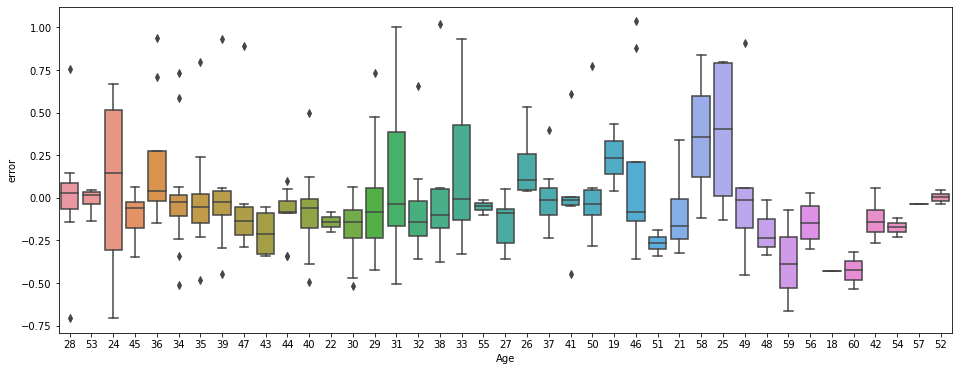

In [108]:
plt.figure(figsize = (16, 6))
sn.boxplot( data = cars_df_prod,
            x = 'Age',
            y = 'error',
            order = car_makes);

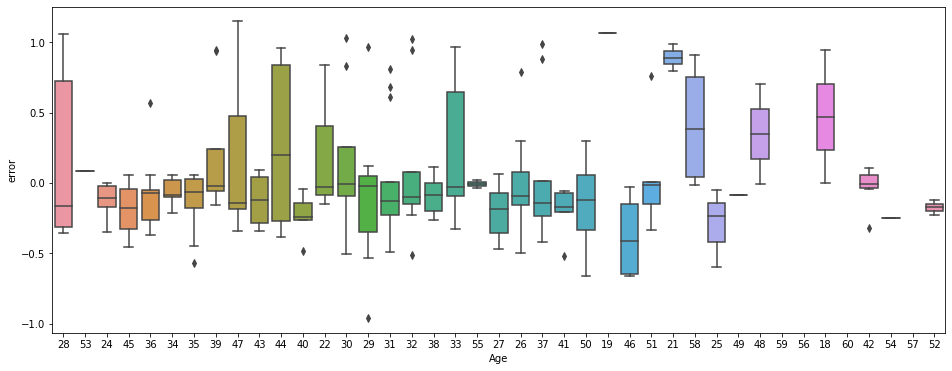

In [110]:
plt.figure(figsize = (16, 6))
sn.boxplot( data = x_train,
            x = 'Age',
            y = 'error',
            order = car_makes);

In [114]:
error_by_make_location = pd.crosstab(cars_df_prod.Age, cars_df_prod.Education, values = cars_df_prod.error, aggfunc = 'median' )

In [115]:
error_by_make_location

Education,1,2,3,4,5
Age,,,,,
18,NaN,NaN,-0.429142,NaN,NaN
19,NaN,0.432329,0.039464,NaN,NaN
21,NaN,-0.212789,-0.121542,NaN,NaN
22,-0.080415,-0.197491,NaN,NaN,NaN
24,-0.119214,NaN,0.248456,NaN,NaN
25,-0.001027,NaN,0.783782,0.037838,NaN
26,NaN,0.164540,0.285308,0.050728,NaN
27,NaN,NaN,-0.109566,0.049170,NaN
28,0.077321,0.148431,-0.024703,0.007347,NaN


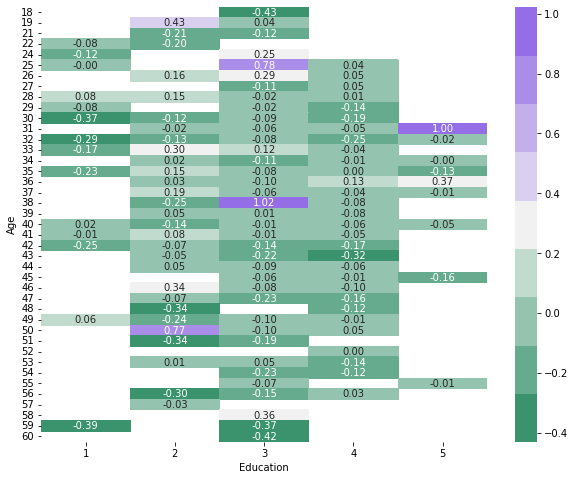

In [116]:
plt.figure(figsize = (10, 8))
sn.heatmap(error_by_make_location, annot = True, fmt = "0.2f", cmap = sn.diverging_palette(150, 275, s=80, l=55, n=9));

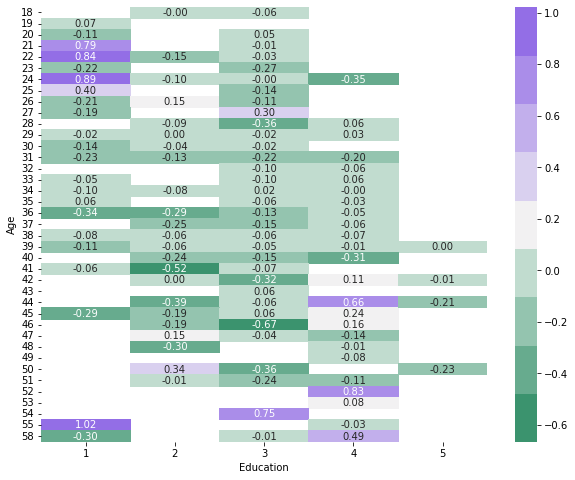

In [119]:
train_error_by_make_location = pd.crosstab(x_train.Age, x_train.Education, values = cars_df_prod.error, aggfunc = 'median' )
plt.figure(figsize = (10, 8))
sn.heatmap(train_error_by_make_location, annot = True, fmt = "0.2f", cmap = sn.diverging_palette(150, 275, s=80, l=55, n=9));